<a href="https://colab.research.google.com/github/shahriarivari/Load-Forecasting-Machine-Learing/blob/main/load_forecasting_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installing libraries

In [1]:
# installing jdatetime for converting date to Gregotian
# !pip install scikit-learn
# !pip install matplotlib
!pip install jdatetime
!pip install scikit-optimize
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.0 MB/s eta 0:00:00


# data manipulation

inculding: 1-becoming one with data, 2-feature engieering, and 3-preprocessing

In [2]:
import pandas as pd # to import the excel file
import numpy as np  # to deal with numbers
import jdatetime    # to convert Jalali datatime to Gregorian

## importing data files
data_df = pd.read_excel("consumption.xlsx") # includes each day in a row with hours of the day as columns
temp_df = pd.read_csv("temperature.csv") # includes the temprature of eaach day

# adding another column "time" which are the dates in Gregorian format and then removing the "date" column
# Apply the conversion directly using a lambda function
data_df['time'] = data_df['date'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))
data_df.drop(columns="date",axis = 1, inplace=True)

In [3]:
# making the dataframe into a column vector of time and power consumption
# we make to lists of hours and their repective values and then concatenate them
time_hourly = []
values_hourly = []
list_of_hours = np.arange(1,25)
for i in range(len(data_df["time"])):
    time = pd.to_datetime(data_df['time'][i], format='%Y-%m-%d') + pd.to_timedelta(list_of_hours, unit='h').values
    values = data_df.loc[i][:-1].values
    time_hourly.append(time)
    values_hourly.append(values)

time_concatenated = np.concatenate(time_hourly)
values_concatenated = np.concatenate(values_hourly)

# and now we make the new df
new_df = pd.DataFrame({"time": time_concatenated, "power": values_concatenated})
print(f" changed the data frame from {data_df.shape} to {new_df.shape} ")


# adding another column to the new_df, which is the temperature of each hour using the temp_df
temp_df["time"] = pd.to_datetime(temp_df['time'], format='%Y-%m-%d') # changing the format to pd.datetime
# Concatenate based on the 'Time' column
concat_df = pd.concat([new_df.set_index('time'), temp_df.set_index('time')], axis=1, join='inner')
# Reset the index to make 'Time' a column again
concat_df.reset_index(inplace=True)
concat_df.head(2)

 changed the data frame from (730, 25) to (17520, 2) 


,time,power,temp
0,2021-03-21 01:00:00,683.189471,6.7
1,2021-03-21 02:00:00,627.645948,6.1


### adding features to the dataset
up untill now we've made a new data frame with "time" indicating each day and hour with its respective "power" and "temp".
Now we try addind new features based on the information we have, to feed it to our model

In [4]:
# addding mutiple columns using the "time" col
concat_df["week_day"] = concat_df["time"].dt.weekday
concat_df["day"] = concat_df["time"].dt.day
concat_df['month'] = concat_df["time"].dt.month
concat_df["hour"] = concat_df["time"].dt.hour

# extracting features
concat_df['up_of_month']=(concat_df['day']<=10).astype(int)
concat_df['down_of_month']=(concat_df['day']>20).astype(int)
concat_df['sin_day']=np.sin(2*np.pi*concat_df['day']/30)
concat_df['cos_day']=np.cos(2*np.pi*concat_df['day']/30)

concat_df['morning']=((concat_df['hour']>5)&(concat_df['hour']<=12)).astype(int)
concat_df['afternoon']=((concat_df['hour']>12)&(concat_df['hour']<=19)).astype(int)
concat_df['evening']=(1-concat_df['morning']-concat_df['afternoon']).astype(int)

#  whether its thursday | friday or not
concat_df['weekend'] = ((concat_df["week_day"] == 4) | (concat_df["week_day"] == 3)).astype(int)
concat_df['time_slot'] = pd.cut(concat_df["hour"], bins=[0, 6, 12, 18, 24], labels=[1, 2, 3, 4], right=False)
concat_df['peak_load'] = ((concat_df["hour"] >= 11) & (concat_df["hour"] <= 15)).astype(int)

concat_df['spring']=((concat_df['month']>=3)&(concat_df['month']<=5)).astype(int)
concat_df['summer']=((concat_df['month']>=6)&(concat_df['month']<=8)).astype(int)
concat_df['fall']=((concat_df['month']>=9)&(concat_df['month']<=11)).astype(int)
concat_df['winter']=((concat_df['month']==12)&(concat_df['month']<=2)).astype(int)

# adding the mean of the past 4 "values" for each row
previous_four_mean = np.array(concat_df["power"][0:4].values).astype(np.float32)
for i in range(4,len(concat_df)):
  previous_four_mean = np.append(previous_four_mean, concat_df["power"][i-4:i].values.mean()).astype(np.float32)
concat_df["four_mean"] = previous_four_mean

# dropping non-informative columns
concat_df.drop( ["day", "week_day", "month","hour"] , axis = 1, inplace = True)

print(f"number of features: {len(concat_df.columns)}, including the 'time' column\n columns are :\n{concat_df.columns.values}")

number of features: 18, including the 'time' column
 columns are :
['time' 'power' 'temp' 'up_of_month' 'down_of_month' 'sin_day' 'cos_day'
 'morning' 'afternoon' 'evening' 'weekend' 'time_slot' 'peak_load'
 'spring' 'summer' 'fall' 'winter' 'four_mean']


### plotting to get some information
plotting the "power" with respect to temperatue and time to see the relation between them


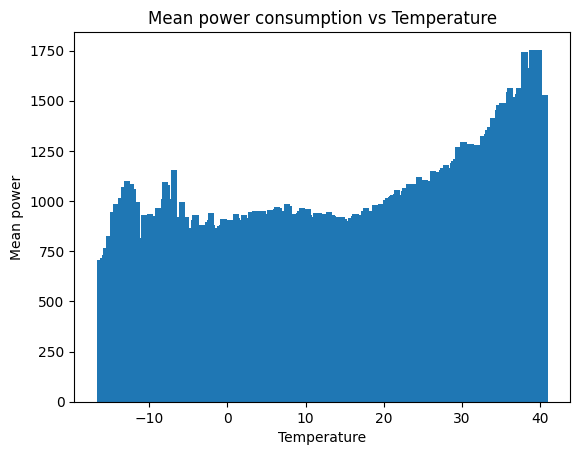

In [5]:
# plotting temperatue vs power consumption
import matplotlib.pyplot as plt
unique_temps = np.unique(concat_df['temp'])
# Plotting
plt.bar(unique_temps, concat_df.groupby('temp')['power'].mean())
plt.xlabel('Temperature')
plt.ylabel('Mean power')
plt.title('Mean power consumption vs Temperature')
plt.show()

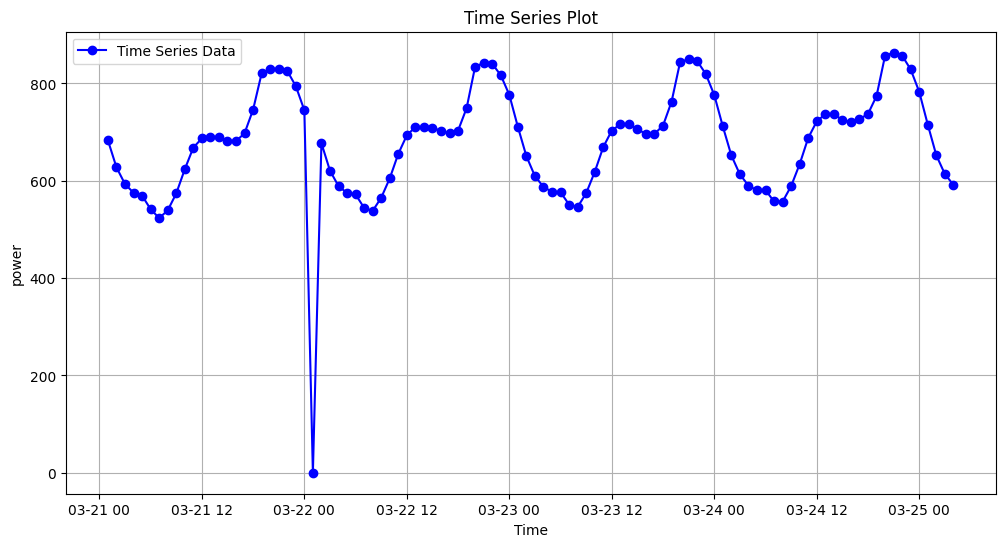

In [6]:
# Plotting the power over the time column
plt.figure(figsize=(12, 6))
plt.plot(concat_df['time'][:100], concat_df['power'][:100], label='Time Series Data', marker='o', linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('power')
plt.legend()
plt.grid(True)
plt.show()

### Normalizing using the Standard Deviation Normalization method

In [7]:
# normalizing the value and mean columns
# Normalizing using the Standard Deviation Normalization method
concat_df_value_mean = concat_df["power"].mean()
concat_df_value_std = concat_df["power"].std()
concat_df.loc[:, "power"] = (concat_df["power"] - concat_df_value_mean) / concat_df_value_std

concat_df_four_mean_mean = concat_df["four_mean"].mean()
concat_df_four_mean_std = concat_df["four_mean"].std()
concat_df.loc[:, "four_mean"] = (concat_df["four_mean"] - concat_df_four_mean_mean) / concat_df_four_mean_std

# changed the "values" columns dtype to float
concat_df["power"] = pd.to_numeric(concat_df['power'], errors='coerce').astype(float)

In [8]:
# adding 3 more features, which are the values of three previous hours
concat_df['one_hour_ago'] = concat_df['power'].shift(1)
concat_df['two_hours_ago'] = concat_df['power'].shift(2)
concat_df['three_hours_ago'] = concat_df['power'].shift(3)
columns_to_fill = ['one_hour_ago', 'two_hours_ago', 'three_hours_ago']
concat_df[columns_to_fill] = concat_df[columns_to_fill].fillna(method='bfill')

# Lightgbm Model
For our first model we are going to use Gradient Boosting Models using the "lightgbm" framework which uses tree based learning algorithms.


In [9]:
from sklearn.model_selection import KFold #Import the k-fold cross validation function in the machine learning library
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import lightgbm as lgb

### train and test split

In [10]:
# Drop any other columns that are not features or the target variable
features = concat_df.drop(columns=['power','time'],axis =1)
target = concat_df['power']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

## hyper-parameter tuning , using the BayesianOptimization

In [11]:
# Define the objective function for Bayesian Optimization
def lgbm_cv(num_leaves, learning_rate, n_estimators, feature_fraction, bagging_fraction, bagging_freq, min_child_samples):
  params = {
    'objective': 'regression',
    'num_leaves': int(num_leaves),
    'learning_rate': learning_rate,
    'n_estimators': int(n_estimators),
    'feature_fraction': max(min(feature_fraction, 1), 0),
    'bagging_fraction': max(min(bagging_fraction, 1), 0),
    'bagging_freq': int(bagging_freq),
    'min_child_samples': int(min_child_samples),
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt'
    }

  # Perform K-Fold cross-validation on the training set
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  rmse_scores = []

  for train_index, val_index in kf.split(X_train):
    X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_kf, y_train_kf)

    # Predict on the validation set and calculate RMSE
    y_pred = model.predict(X_val_kf)
    rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred))
    rmse_scores.append(rmse)

  # Return the average RMSE across folds
  return -np.mean(rmse_scores)

# Define the parameter space for Bayesian Optimization
pbounds = {
  'num_leaves': (5, 50),
  'learning_rate': (0.01, 0.3),
  'n_estimators': (50, 200),
  'feature_fraction': (0.1, 0.9),
  'bagging_fraction': (0.1, 0.9),
  'bagging_freq': (1, 10),
  'min_child_samples': (5, 30)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
  f=lgbm_cv,
  pbounds=pbounds,
  random_state=42,
)

# Run Bayesian Optimization
optimizer.maximize(init_points=10, n_iter=30)

# Get the best hyperparameters
best_params = optimizer.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['bagging_freq'] = int(best_params['bagging_freq'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])

|   iter    |  target   | baggin... | baggin... | featur... | learni... | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.1553   | 0.3996    | 9.556     | 0.6856    | 0.1836    | 8.9       | 73.4      | 7.614     |
| 2         | -0.1886   | 0.7929    | 6.41      | 0.6665    | 0.01597   | 29.25     | 174.9     | 14.56     |
| 3         | -0.1618   | 0.2455    | 2.651     | 0.3434    | 0.1622    | 15.8      | 93.68     | 32.53     |
| 4         | -0.1504   | 0.2116    | 3.629     | 0.3931    | 0.1423    | 24.63     | 79.95     | 28.14     |
| 5         | -0.1251   | 0.5739    | 1.418     | 0.586     | 0.05945   | 6.626     | 192.3     | 48.45     |
| 6         | -0.1818   | 0.7467    | 3.742     | 0.1781    | 0.2084    | 16.0      | 68.31     | 27.28     |
| 7         | -0.1726   | 0.1275    | 9.184     | 0.307     | 0.2021    | 12.79     | 128.0     | 29.6      |
| 8       

## training phase
train the model using the "best_params"

In [12]:
best_params

{'bagging_fraction': 0.40312747751207423,
 'bagging_freq': 2,
 'feature_fraction': 0.8861754497516044,
 'learning_rate': 0.1260292569340899,
 'min_child_samples': 6,
 'n_estimators': 191,
 'num_leaves': 48}

In [13]:
# Train the final model with the best hyperparameters using the entire training set
best_params['metric'] = 'rmse'
best_params['verbosity'] = -1
best_params['boosting_type'] = 'gbdt'
best_params['objective'] = 'regression'

final_model = lgb.LGBMRegressor(**best_params)
early_stopping = lgb.early_stopping(50, first_metric_only=False, verbose=True, min_delta=0.001)

# Fit the model with early stopping
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',  # Evaluation metric for early stopping and reporting
    callbacks = [early_stopping]
)
# final_model.fit(X_train, y_train,
#                 early_stopping_rounds=10)

# Evaluate the final model on the test set and the training set
y_pred_train = final_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Final model RMSE on the training set: {rmse_train}")

y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Final model RMSE on the test set: {rmse_test}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's rmse: 0.095757
Final model RMSE on the training set: 0.08151407707426736
Final model RMSE on the test set: 0.09575702576633709


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

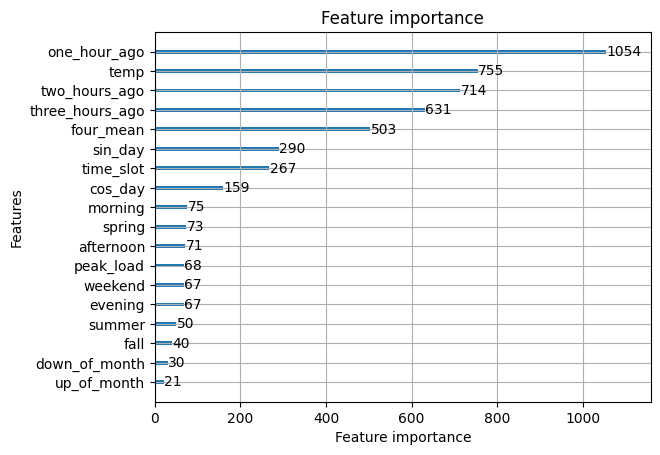

In [14]:
lgb.plot_importance(final_model)

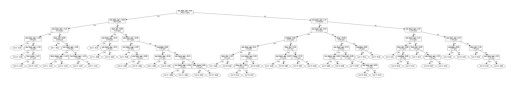

In [26]:
lgb.plot_tree(final_model, tree_index = 0, show_info=['split_gain'], precision=2, orientation='vertical')
# Save the plot as a PNG file with higher DPI
plt.savefig('tree_plot.png', dpi=1200)

## plotting the results
plotting the actual values and preicted ones for both training and testing data

In [27]:
actual_train_values = concat_df.loc[X_train.index, ['time','power']].sort_index()
actual_train_values['predicted_power'] = final_model.predict(X_train.sort_index())
print(actual_train_values.head())
rmse_train = np.sqrt(mean_squared_error(actual_train_values['power'], actual_train_values['predicted_power']))
print(f"Final model RMSE on the train set: {rmse_train}")

                 time     power  predicted_power
1 2021-03-21 02:00:00 -1.712721        -1.417448
2 2021-03-21 03:00:00 -1.874550        -1.740823
4 2021-03-21 05:00:00 -1.986965        -1.905533
6 2021-03-21 07:00:00 -2.204027        -2.005255
7 2021-03-21 08:00:00 -2.129774        -1.970298
Final model RMSE on the train set: 0.08151407707426736


In [28]:
actual_test_values = concat_df.loc[X_test.index, ['time','power']].sort_index()
actual_test_values['predicted_power'] = final_model.predict(X_test.sort_index())
print(actual_train_values.head())
rmse_test = np.sqrt(mean_squared_error(actual_test_values['power'], actual_test_values['predicted_power']))
print(f"Final model RMSE on the test set: {rmse_test}")

                 time     power  predicted_power
1 2021-03-21 02:00:00 -1.712721        -1.417448
2 2021-03-21 03:00:00 -1.874550        -1.740823
4 2021-03-21 05:00:00 -1.986965        -1.905533
6 2021-03-21 07:00:00 -2.204027        -2.005255
7 2021-03-21 08:00:00 -2.129774        -1.970298
Final model RMSE on the test set: 0.09575702576633709


### denormalization stage

In [29]:
actual_train_values['power'] = (actual_train_values['power']*concat_df_value_std) +concat_df_value_mean
actual_train_values['predicted_power'] = (actual_train_values['predicted_power']*concat_df_value_std) +concat_df_value_mean

actual_test_values['power'] = (actual_test_values['power']*concat_df_value_std) +concat_df_value_mean
actual_test_values['predicted_power'] = (actual_test_values['predicted_power']*concat_df_value_std) +concat_df_value_mean

### plots

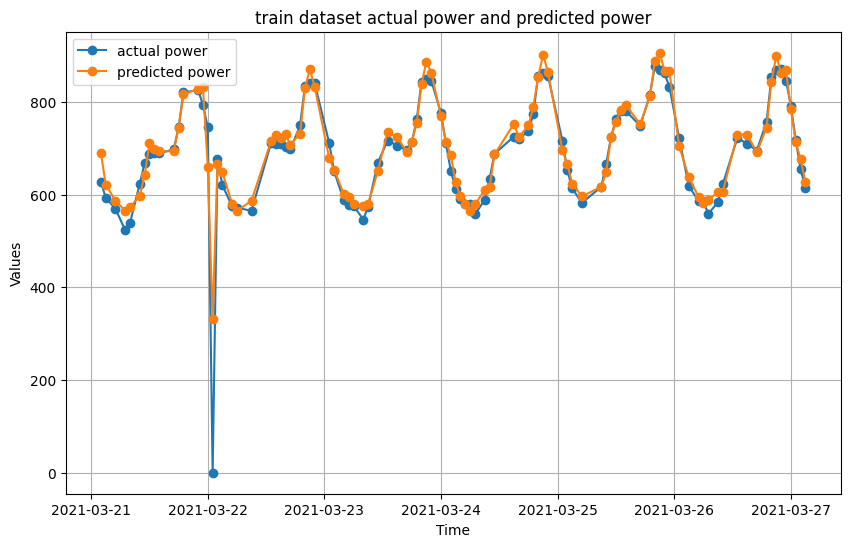

In [30]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting Value1 against Time
plt.plot(actual_train_values['time'][:100], actual_train_values['power'][:100], label='actual power', marker='o', linestyle='-')

# Plotting Value2 against Time
plt.plot(actual_train_values['time'][:100], actual_train_values['predicted_power'][:100], label='predicted power', marker='o', linestyle='-')

plt.title('train dataset actual power and predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

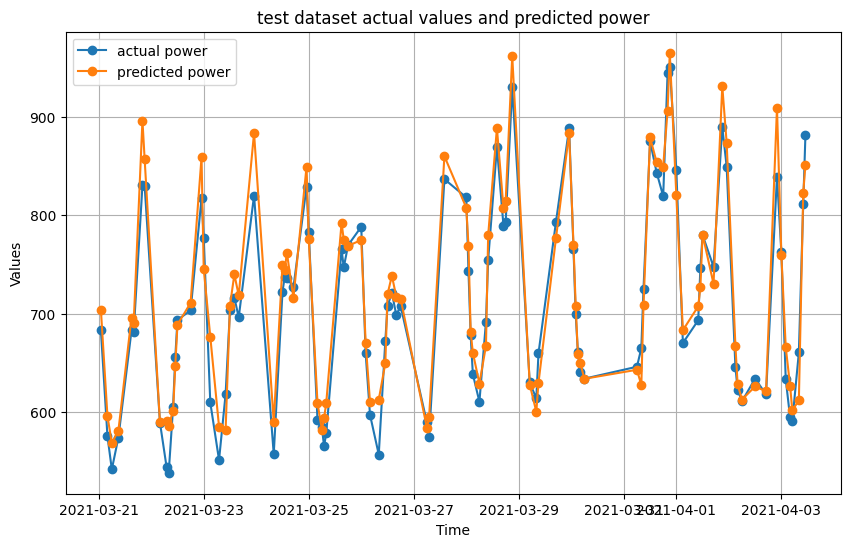

In [31]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting Value1 against Time
plt.plot(actual_test_values['time'][:100], actual_test_values['power'][:100], label='actual power', marker='o', linestyle='-')

# Plotting Value2 against Time
plt.plot(actual_test_values['time'][:100], actual_test_values['predicted_power'][:100], label='predicted power', marker='o', linestyle='-')

plt.title('test dataset actual values and predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Neural Network model
developing a simple MLP for regression task using Pytorch framework

In [34]:
# Standard PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## train-test split

In [35]:
# convert the data to a PyTorch tensor
X = torch.tensor(concat_df.drop(columns=['power','time'],axis =1).values, dtype=torch.float32)
y = torch.tensor(concat_df["power"].values, dtype=torch.float32)
y = y.view(-1,1)
# splitting the data into three parts , train, eval and test

# Split the data into training and the rest (temp_data)
X_train, temp_data, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Split the temp_data into evaluation and test sets
X_eval, X_test, y_eval, y_test = train_test_split(temp_data, y_temp, test_size=0.5, random_state=42)


# Convert data to PyTorch DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

## constructing the model

In [36]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size:int, num_hidden_units:int, num_layers:int):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, num_hidden_units))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_hidden_units, num_hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=0.2))
        layers.append(nn.Linear(num_hidden_units, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Grid-search hyper-parameter tuning

In [37]:
# Grid search hyperparameter tuning
param_grid = {
    'num_hidden_units': [16, 32],
    'num_layers': [2, 3,4],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [38]:
best_model = None
best_params = None
best_loss = float('inf')

In [39]:
from helper_functions import train, train_step, test_step

In [40]:
# for loop to search the parameter space for the best parameters
# Convert test data to PyTorch tensor
eval_data = (X_eval, y_eval)
test_data = (X_test, y_test)
counter = 1

for params in ParameterGrid(param_grid):
  print(f"{counter} set of params in total {len(ParameterGrid(param_grid))}")
  learning_rate = params['learning_rate']
  del params['learning_rate']  # Remove learning_rate from params

  model = NeuralNetwork(input_size=X.shape[1], **params).to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # train the model
  results = train(model=model,
                  train_dataloader = train_loader,
                  test_data = eval_data,
                  optimizer = optimizer,
                  criterion = criterion,
                  epochs = 10,
                  device = device)

  # now test the model on test data
  test_loss = test_step(model=model,
                        test_data = test_data,
                        criterion = criterion,
                        device = device)
  if test_loss < best_loss:
    best_loss = test_loss
    best_model = model
    best_params = params
    best_learning_rate = learning_rate

  counter +=1

print("Best Hyperparameters:", best_params)
print("Best Test Loss:", best_loss)
print("Best Learning Rate:", best_learning_rate)

1 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2632 | test_loss: 0.0398 | 
Epoch: 2 | train_loss: 0.0804 | test_loss: 0.0228 | 
Epoch: 3 | train_loss: 0.0742 | test_loss: 0.0246 | 
Epoch: 4 | train_loss: 0.0704 | test_loss: 0.0199 | 
Epoch: 5 | train_loss: 0.0661 | test_loss: 0.0170 | 
Epoch: 6 | train_loss: 0.0662 | test_loss: 0.0281 | 
Epoch: 7 | train_loss: 0.0639 | test_loss: 0.0196 | 
Epoch: 8 | train_loss: 0.0653 | test_loss: 0.0207 | 
Epoch: 9 | train_loss: 0.0631 | test_loss: 0.0331 | 
Epoch: 10 | train_loss: 0.0662 | test_loss: 0.0148 | 
2 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2984 | test_loss: 0.0727 | 
Epoch: 2 | train_loss: 0.1123 | test_loss: 0.0471 | 
Epoch: 3 | train_loss: 0.0945 | test_loss: 0.0497 | 
Epoch: 4 | train_loss: 0.0885 | test_loss: 0.0533 | 
Epoch: 5 | train_loss: 0.0864 | test_loss: 0.0359 | 
Epoch: 6 | train_loss: 0.0825 | test_loss: 0.0481 | 
Epoch: 7 | train_loss: 0.0778 | test_loss: 0.0519 | 
Epoch: 8 | train_loss: 0.0787 | test_loss: 0.0446 | 
Epoch: 9 | train_loss: 0.0788 | test_loss: 0.0438 | 
Epoch: 10 | train_loss: 0.0736 | test_loss: 0.0419 | 
3 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3144 | test_loss: 0.0709 | 
Epoch: 2 | train_loss: 0.1333 | test_loss: 0.0488 | 
Epoch: 3 | train_loss: 0.1105 | test_loss: 0.0487 | 
Epoch: 4 | train_loss: 0.1032 | test_loss: 0.0611 | 
Epoch: 5 | train_loss: 0.1005 | test_loss: 0.0701 | 
Epoch: 6 | train_loss: 0.0890 | test_loss: 0.0652 | 
Epoch: 7 | train_loss: 0.0897 | test_loss: 0.0516 | 
Epoch: 8 | train_loss: 0.0876 | test_loss: 0.0706 | 
Epoch: 9 | train_loss: 0.0864 | test_loss: 0.0458 | 
Epoch: 10 | train_loss: 0.0840 | test_loss: 0.0736 | 
4 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1487 | test_loss: 0.0369 | 
Epoch: 2 | train_loss: 0.0571 | test_loss: 0.0201 | 
Epoch: 3 | train_loss: 0.0510 | test_loss: 0.0203 | 
Epoch: 4 | train_loss: 0.0487 | test_loss: 0.0196 | 
Epoch: 5 | train_loss: 0.0473 | test_loss: 0.0198 | 
Epoch: 6 | train_loss: 0.0447 | test_loss: 0.0160 | 
Epoch: 7 | train_loss: 0.0436 | test_loss: 0.0180 | 
Epoch: 8 | train_loss: 0.0436 | test_loss: 0.0139 | 
Epoch: 9 | train_loss: 0.0425 | test_loss: 0.0179 | 
Epoch: 10 | train_loss: 0.0419 | test_loss: 0.0169 | 
5 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1613 | test_loss: 0.0347 | 
Epoch: 2 | train_loss: 0.0723 | test_loss: 0.0324 | 
Epoch: 3 | train_loss: 0.0633 | test_loss: 0.0215 | 
Epoch: 4 | train_loss: 0.0609 | test_loss: 0.0303 | 
Epoch: 5 | train_loss: 0.0562 | test_loss: 0.0358 | 
Epoch: 6 | train_loss: 0.0526 | test_loss: 0.0209 | 
Epoch: 7 | train_loss: 0.0523 | test_loss: 0.0236 | 
Epoch: 8 | train_loss: 0.0508 | test_loss: 0.0238 | 
Epoch: 9 | train_loss: 0.0515 | test_loss: 0.0192 | 
Epoch: 10 | train_loss: 0.0503 | test_loss: 0.0198 | 
6 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2122 | test_loss: 0.0413 | 
Epoch: 2 | train_loss: 0.0875 | test_loss: 0.0328 | 
Epoch: 3 | train_loss: 0.0750 | test_loss: 0.0338 | 
Epoch: 4 | train_loss: 0.0743 | test_loss: 0.0299 | 
Epoch: 5 | train_loss: 0.0661 | test_loss: 0.0332 | 
Epoch: 6 | train_loss: 0.0658 | test_loss: 0.0217 | 
Epoch: 7 | train_loss: 0.0625 | test_loss: 0.0422 | 
Epoch: 8 | train_loss: 0.0609 | test_loss: 0.0303 | 
Epoch: 9 | train_loss: 0.0610 | test_loss: 0.0221 | 
Epoch: 10 | train_loss: 0.0564 | test_loss: 0.0379 | 
7 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1121 | test_loss: 0.0688 | 
Epoch: 2 | train_loss: 0.0818 | test_loss: 0.0412 | 
Epoch: 3 | train_loss: 0.0755 | test_loss: 0.0381 | 
Epoch: 4 | train_loss: 0.0803 | test_loss: 0.0300 | 
Epoch: 5 | train_loss: 0.0808 | test_loss: 0.0294 | 
Epoch: 6 | train_loss: 0.0780 | test_loss: 0.0432 | 
Epoch: 7 | train_loss: 0.0749 | test_loss: 0.0378 | 
Epoch: 8 | train_loss: 0.0792 | test_loss: 0.0414 | 
Epoch: 9 | train_loss: 0.0784 | test_loss: 0.0308 | 
Epoch: 10 | train_loss: 0.0728 | test_loss: 0.0169 | 
8 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1634 | test_loss: 0.0734 | 
Epoch: 2 | train_loss: 0.1165 | test_loss: 0.0329 | 
Epoch: 3 | train_loss: 0.1085 | test_loss: 0.0426 | 
Epoch: 4 | train_loss: 0.0996 | test_loss: 0.0342 | 
Epoch: 5 | train_loss: 0.0923 | test_loss: 0.0344 | 
Epoch: 6 | train_loss: 0.1042 | test_loss: 0.0569 | 
Epoch: 7 | train_loss: 0.0966 | test_loss: 0.0589 | 
Epoch: 8 | train_loss: 0.0999 | test_loss: 0.0399 | 
Epoch: 9 | train_loss: 0.0962 | test_loss: 0.0214 | 
Epoch: 10 | train_loss: 0.0991 | test_loss: 0.0504 | 
9 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1888 | test_loss: 0.0549 | 
Epoch: 2 | train_loss: 0.1339 | test_loss: 0.0520 | 
Epoch: 3 | train_loss: 0.1298 | test_loss: 0.0566 | 
Epoch: 4 | train_loss: 0.1143 | test_loss: 0.0705 | 
Epoch: 5 | train_loss: 0.1170 | test_loss: 0.0561 | 
Epoch: 6 | train_loss: 0.1152 | test_loss: 0.0320 | 
Epoch: 7 | train_loss: 0.1664 | test_loss: 0.0519 | 
Epoch: 8 | train_loss: 0.1643 | test_loss: 0.1184 | 
Epoch: 9 | train_loss: 0.1691 | test_loss: 0.0611 | 
Epoch: 10 | train_loss: 0.1517 | test_loss: 0.0652 | 
10 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0994 | test_loss: 0.0266 | 
Epoch: 2 | train_loss: 0.0645 | test_loss: 0.0230 | 
Epoch: 3 | train_loss: 0.0709 | test_loss: 0.0284 | 
Epoch: 4 | train_loss: 0.0641 | test_loss: 0.0190 | 
Epoch: 5 | train_loss: 0.0639 | test_loss: 0.0192 | 
Epoch: 6 | train_loss: 0.0601 | test_loss: 0.0243 | 
Epoch: 7 | train_loss: 0.0633 | test_loss: 0.0202 | 
Epoch: 8 | train_loss: 0.0583 | test_loss: 0.0363 | 
Epoch: 9 | train_loss: 0.0589 | test_loss: 0.0173 | 
Epoch: 10 | train_loss: 0.0554 | test_loss: 0.0167 | 
11 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1503 | test_loss: 0.0412 | 
Epoch: 2 | train_loss: 0.0874 | test_loss: 0.0334 | 
Epoch: 3 | train_loss: 0.0899 | test_loss: 0.0202 | 
Epoch: 4 | train_loss: 0.0815 | test_loss: 0.0930 | 
Epoch: 5 | train_loss: 0.0777 | test_loss: 0.0864 | 
Epoch: 6 | train_loss: 0.0760 | test_loss: 0.1320 | 
Epoch: 7 | train_loss: 0.0776 | test_loss: 0.0425 | 
Epoch: 8 | train_loss: 0.0790 | test_loss: 0.0223 | 
Epoch: 9 | train_loss: 0.0814 | test_loss: 0.0702 | 
Epoch: 10 | train_loss: 0.0732 | test_loss: 0.0719 | 
12 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1625 | test_loss: 0.0412 | 
Epoch: 2 | train_loss: 0.1104 | test_loss: 0.0671 | 
Epoch: 3 | train_loss: 0.1112 | test_loss: 0.0668 | 
Epoch: 4 | train_loss: 0.1115 | test_loss: 0.0476 | 
Epoch: 5 | train_loss: 0.1001 | test_loss: 0.0364 | 
Epoch: 6 | train_loss: 0.1190 | test_loss: 0.0602 | 
Epoch: 7 | train_loss: 0.1089 | test_loss: 0.0638 | 
Epoch: 8 | train_loss: 0.1189 | test_loss: 0.1579 | 
Epoch: 9 | train_loss: 0.1265 | test_loss: 0.0567 | 
Epoch: 10 | train_loss: 0.1244 | test_loss: 0.0490 | 
13 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4335 | test_loss: 0.5050 | 
Epoch: 2 | train_loss: 0.7408 | test_loss: 0.4779 | 
Epoch: 3 | train_loss: 0.6745 | test_loss: 1.0120 | 
Epoch: 4 | train_loss: 1.0033 | test_loss: 1.0173 | 
Epoch: 5 | train_loss: 1.0114 | test_loss: 1.0192 | 
Epoch: 6 | train_loss: 1.0094 | test_loss: 1.0127 | 
Epoch: 7 | train_loss: 1.0057 | test_loss: 1.0363 | 
Epoch: 8 | train_loss: 1.0091 | test_loss: 1.0372 | 
Epoch: 9 | train_loss: 1.0108 | test_loss: 1.0116 | 
Epoch: 10 | train_loss: 1.0074 | test_loss: 1.0117 | 
14 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7099 | test_loss: 1.0003 | 
Epoch: 2 | train_loss: 0.8491 | test_loss: 0.6010 | 
Epoch: 3 | train_loss: 0.8955 | test_loss: 0.9484 | 
Epoch: 4 | train_loss: 0.8751 | test_loss: 0.7821 | 
Epoch: 5 | train_loss: 0.8024 | test_loss: 0.5684 | 
Epoch: 6 | train_loss: 0.7889 | test_loss: 0.4967 | 
Epoch: 7 | train_loss: 0.7996 | test_loss: 0.6697 | 
Epoch: 8 | train_loss: 0.8020 | test_loss: 0.5496 | 
Epoch: 9 | train_loss: 0.7939 | test_loss: 0.6036 | 
Epoch: 10 | train_loss: 0.8003 | test_loss: 0.5987 | 
15 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9066 | test_loss: 1.0331 | 
Epoch: 2 | train_loss: 1.0088 | test_loss: 1.0135 | 
Epoch: 3 | train_loss: 1.0097 | test_loss: 1.0191 | 
Epoch: 4 | train_loss: 1.0087 | test_loss: 1.0162 | 
Epoch: 5 | train_loss: 1.0135 | test_loss: 1.0220 | 
Epoch: 6 | train_loss: 1.0071 | test_loss: 1.0159 | 
Epoch: 7 | train_loss: 1.0044 | test_loss: 1.0163 | 
Epoch: 8 | train_loss: 1.0068 | test_loss: 1.0165 | 
Epoch: 9 | train_loss: 1.0075 | test_loss: 1.0122 | 
Epoch: 10 | train_loss: 1.0069 | test_loss: 1.0285 | 
16 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5501 | test_loss: 0.2150 | 
Epoch: 2 | train_loss: 0.5702 | test_loss: 0.4730 | 
Epoch: 3 | train_loss: 0.5168 | test_loss: 0.5255 | 
Epoch: 4 | train_loss: 0.5802 | test_loss: 0.4933 | 
Epoch: 5 | train_loss: 0.6183 | test_loss: 0.5416 | 
Epoch: 6 | train_loss: 0.6377 | test_loss: 0.7445 | 
Epoch: 7 | train_loss: 0.6549 | test_loss: 0.6062 | 
Epoch: 8 | train_loss: 0.6726 | test_loss: 0.4975 | 
Epoch: 9 | train_loss: 0.6400 | test_loss: 0.5758 | 
Epoch: 10 | train_loss: 0.6131 | test_loss: 0.4890 | 
17 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6484 | test_loss: 0.6116 | 
Epoch: 2 | train_loss: 0.7561 | test_loss: 0.9805 | 
Epoch: 3 | train_loss: 0.9240 | test_loss: 1.1088 | 
Epoch: 4 | train_loss: 1.0112 | test_loss: 1.0124 | 
Epoch: 5 | train_loss: 1.0071 | test_loss: 1.0325 | 
Epoch: 6 | train_loss: 1.0134 | test_loss: 1.0116 | 
Epoch: 7 | train_loss: 1.0066 | test_loss: 1.0292 | 
Epoch: 8 | train_loss: 1.0113 | test_loss: 1.0124 | 
Epoch: 9 | train_loss: 1.0086 | test_loss: 1.0309 | 
Epoch: 10 | train_loss: 1.0077 | test_loss: 1.0148 | 
18 set of params in total 18


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3194 | test_loss: 1.0229 | 
Epoch: 2 | train_loss: 1.0114 | test_loss: 1.0135 | 
Epoch: 3 | train_loss: 1.0087 | test_loss: 1.0119 | 
Epoch: 4 | train_loss: 1.0116 | test_loss: 1.0285 | 
Epoch: 5 | train_loss: 1.0109 | test_loss: 1.0178 | 
Epoch: 6 | train_loss: 1.0110 | test_loss: 1.0160 | 
Epoch: 7 | train_loss: 1.0073 | test_loss: 1.0497 | 
Epoch: 8 | train_loss: 1.0094 | test_loss: 1.0213 | 
Epoch: 9 | train_loss: 1.0080 | test_loss: 1.0131 | 
Epoch: 10 | train_loss: 1.0092 | test_loss: 1.0140 | 
Best Hyperparameters: {'num_hidden_units': 16, 'num_layers': 2}
Best Test Loss: 0.015174358151853085
Best Learning Rate: 0.001


## training model using the grid search hyper-parameter method

In [41]:
# Train the best model on the entire dataset
best_model = NeuralNetwork(input_size=X.shape[1], **best_params).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
criterion = nn.MSELoss()

results = train(model= best_model,
                train_dataloader = train_loader,
                test_data = test_data,
                optimizer = optimizer,
                criterion = criterion,
                epochs = 30,
                device = device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2123 | test_loss: 0.0469 | 
Epoch: 2 | train_loss: 0.0793 | test_loss: 0.0265 | 
Epoch: 3 | train_loss: 0.0675 | test_loss: 0.0290 | 
Epoch: 4 | train_loss: 0.0625 | test_loss: 0.0223 | 
Epoch: 5 | train_loss: 0.0619 | test_loss: 0.0204 | 
Epoch: 6 | train_loss: 0.0617 | test_loss: 0.0251 | 
Epoch: 7 | train_loss: 0.0604 | test_loss: 0.0299 | 
Epoch: 8 | train_loss: 0.0604 | test_loss: 0.0159 | 
Epoch: 9 | train_loss: 0.0592 | test_loss: 0.0163 | 
Epoch: 10 | train_loss: 0.0598 | test_loss: 0.0162 | 
Epoch: 11 | train_loss: 0.0587 | test_loss: 0.0223 | 
Epoch: 12 | train_loss: 0.0591 | test_loss: 0.0190 | 
Epoch: 13 | train_loss: 0.0578 | test_loss: 0.0145 | 
Epoch: 14 | train_loss: 0.0557 | test_loss: 0.0141 | 
Epoch: 15 | train_loss: 0.0581 | test_loss: 0.0143 | 
Epoch: 16 | train_loss: 0.0569 | test_loss: 0.0134 | 
Epoch: 17 | train_loss: 0.0555 | test_loss: 0.0143 | 
Epoch: 18 | train_loss: 0.0587 | test_loss: 0.0162 | 
Epoch: 19 | train_loss: 0.0572 | test

In [42]:
denormalized_values = (concat_df["power"] * concat_df_value_std) +concat_df_value_mean
dernomalized_predictions = (best_model(X.to(device)).detach().cpu().numpy() * concat_df_value_std) +concat_df_value_mean

In [43]:
plot_df = pd.DataFrame({"time": concat_df["time"],
                        "actual_values": denormalized_values,
                        "predictions": dernomalized_predictions.flatten()})

In [44]:
train_plot_df = plot_df[:int(len(plot_df)*0.7)]
test_plot_df = plot_df[int(len(plot_df)*0.7):]

In [45]:
rmse_test = np.sqrt(mean_squared_error(concat_df["power"][int(len(concat_df)*0.7):], best_model(X.to(device)).detach().cpu().numpy()[int(len(concat_df)*0.7):].flatten()))
print(f"Final model RMSE on the test set: {rmse_test}")

Final model RMSE on the test set: 0.13936491879481266


## plotting the train and test dataset values vs their predictions

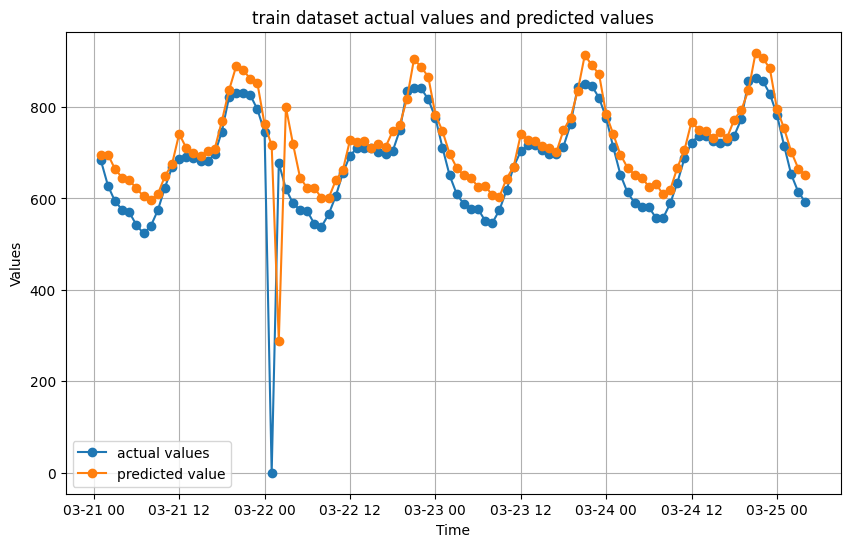

In [46]:
# Plotting train dataset
plt.figure(figsize=(10, 6))

# Plotting actual_values against Time
plt.plot(train_plot_df['time'][:100], train_plot_df['actual_values'][:100], label='actual values', marker='o', linestyle='-')

# Plotting predictions against Time
plt.plot(train_plot_df['time'][:100], train_plot_df['predictions'][:100], label='predicted value', marker='o', linestyle='-')

plt.title('train dataset actual values and predicted values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

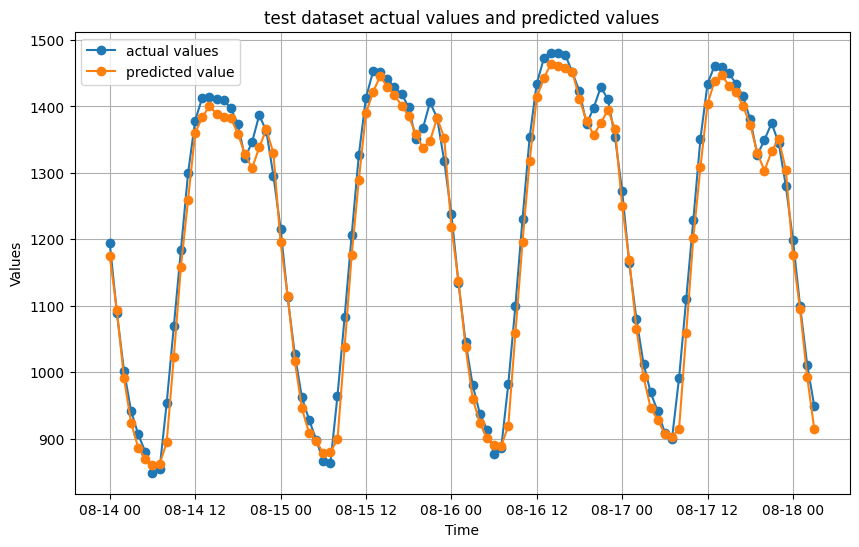

In [47]:
# Plotting test dataset
plt.figure(figsize=(10, 6))

# Plotting actual_values against Time
plt.plot(test_plot_df['time'][:100], test_plot_df['actual_values'][:100], label='actual values', marker='o', linestyle='-')

# Plotting predictions against Time
plt.plot(test_plot_df['time'][:100], test_plot_df['predictions'][:100], label='predicted value', marker='o', linestyle='-')

plt.title('test dataset actual values and predicted values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# LSTM model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### data preparation

In [ ]:
def create_sequences_with_target(data, sequence_length, target_feature_index):
  sequences, targets = [], []
  num_samples, num_features = data.shape

  for i in range(num_samples - sequence_length):
      sequence = data[i:i+sequence_length, :]
      target = data[i+sequence_length, target_feature_index]

      sequences.append(sequence)
      targets.append(target)

  return np.array(sequences), np.array(targets)

In [ ]:
modified_concat_np = concat_df.drop(['four_mean','one_hour_ago', 'two_hours_ago', 'three_hours_ago','time'],axis =1).to_numpy()
print("shape of the modified data is :",modified_concat_np.shape)

shape of the modified data is : (17519, 16)


In [ ]:
# Define the sequence length and target feature index
sequence_length = 5
# the index which we are going to predict is "power" which is 0
target_feature_index = 0

# Create sequences and corresponding targets for the specified feature
sequences, targets = create_sequences_with_target(modified_concat_np, sequence_length, target_feature_index)

print("Original data shape:", modified_concat_np.shape)
print("Sequences shape:", sequences.shape)
print("Targets shape:", targets.shape)


Original data shape: (17519, 16)
Sequences shape: (17514, 5, 16)
Targets shape: (17514,)


### Convert the processed data to PyTorch tensors

In [ ]:
# convert the data to a PyTorch tensor
X = torch.tensor(sequences, dtype=torch.float32)
y = torch.tensor(targets, dtype=torch.float32)
y = y.view(-1,1)
# splitting the data into three parts , train, eval and test

# Split the data into training and the rest (temp_data)
X_train, temp_data, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Split the temp_data into evaluation and test sets
X_eval, X_test, y_eval, y_test = train_test_split(temp_data, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

### constructing the model

In [ ]:
# Custom LSTM implementation
class LSTMRegressor(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out, (hidden, cell) = self.lstm(x)
    out = self.fc(hidden[-1, : , :])
    return out


In [ ]:
# checking the shapes in each batch
for batch , (X,y) in enumerate(train_loader):
  print(f"input size for each batch: {X.shape}")
  print(f"target size for each batch: {y.shape}")
  break

input size for each batch: torch.Size([16, 5, 16])
target size for each batch: torch.Size([16, 1])


### Hyperparameter tuning using grid search

In [ ]:
param_grid = {
    'num_layers': [2, 3],
    'hidden_size': [32, 64],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.0, 0.2, 0.4]
}

In [ ]:
from helper_functions import train, train_step, test_step

In [ ]:
# for loop to search the parameter space for the best parameters
# Convert test data to PyTorch tensor
eval_data = (X_eval, y_eval)
test_data = (X_test, y_test)
counter = 1
# for loop to search the parameter space for the best parameters
best_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
  # Initialize model
  model = LSTMRegressor(input_size= X.shape[2] , # Adjust input size for the number of features
                        hidden_size=params['hidden_size'],
                        num_layers=params['num_layers'],
                        output_size=1,  # Output size for regression
                        dropout_rate=params['dropout_rate']).to(device)

  # loss function
  criterion = nn.MSELoss()
  # optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

  # train the model
  results = train(model=model,
                  train_dataloader = train_loader,
                  test_data = eval_data,
                  optimizer = optimizer,
                  criterion = criterion,
                  epochs = 1,
                  device = device)

  # now test the model on test data
  test_loss = test_step(model=model,
                        test_data = test_data,
                        criterion = criterion,
                        device = device)
  if test_loss < best_loss:
    best_loss = test_loss
    best_model = model
    best_params = params
    best_learning_rate = params['learning_rate']

  counter +=1

print("Best Hyperparameters:", best_params)
print("Best Test Loss:", best_loss)
print("Best Learning Rate:", best_learning_rate)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1175 | test_loss: 0.0244 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1393 | test_loss: 0.0273 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0488 | test_loss: 0.0206 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0575 | test_loss: 0.0115 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1025 | test_loss: 0.0450 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1781 | test_loss: 0.1264 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0950 | test_loss: 0.0182 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1022 | test_loss: 0.0198 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0397 | test_loss: 0.0149 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0581 | test_loss: 0.0129 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5634 | test_loss: 0.2666 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1153 | test_loss: 1.0065 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1350 | test_loss: 0.0255 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1511 | test_loss: 0.0346 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0651 | test_loss: 0.0204 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0812 | test_loss: 0.0280 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1725 | test_loss: 0.0901 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2587 | test_loss: 0.1944 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1011 | test_loss: 0.0270 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1104 | test_loss: 0.0226 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0581 | test_loss: 0.0210 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0731 | test_loss: 0.0322 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3684 | test_loss: 0.1550 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9064 | test_loss: 0.4814 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1602 | test_loss: 0.0385 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1965 | test_loss: 0.0408 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0770 | test_loss: 0.0308 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1119 | test_loss: 0.0459 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2904 | test_loss: 0.2981 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5936 | test_loss: 0.6648 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1176 | test_loss: 0.0280 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1282 | test_loss: 0.0366 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0788 | test_loss: 0.0186 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0905 | test_loss: 0.0255 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4141 | test_loss: 0.2166 | 


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7062 | test_loss: 0.4596 | 
Best Hyperparameters: {'dropout_rate': 0.0, 'hidden_size': 32, 'learning_rate': 0.01, 'num_layers': 3}
Best Test Loss: 0.016887107864022255
Best Learning Rate: 0.01


### train the model on the entire dataset

In [ ]:
# Train the best model on the entire dataset
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
criterion = nn.MSELoss()

results = train(model= best_model,
                train_dataloader = train_loader,
                test_data = test_data,
                optimizer = optimizer,
                criterion = criterion,
                epochs = 30,
                device = device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0223 | test_loss: 0.0124 | 
Epoch: 2 | train_loss: 0.0152 | test_loss: 0.0201 | 
Epoch: 3 | train_loss: 0.0143 | test_loss: 0.0133 | 
Epoch: 4 | train_loss: 0.0153 | test_loss: 0.0196 | 
Epoch: 5 | train_loss: 0.0128 | test_loss: 0.0141 | 
Epoch: 6 | train_loss: 0.0127 | test_loss: 0.0110 | 
Epoch: 7 | train_loss: 0.0121 | test_loss: 0.0153 | 
Epoch: 8 | train_loss: 0.0116 | test_loss: 0.0109 | 
Epoch: 9 | train_loss: 0.0107 | test_loss: 0.0104 | 
Epoch: 10 | train_loss: 0.0110 | test_loss: 0.0095 | 
Epoch: 11 | train_loss: 0.0120 | test_loss: 0.0101 | 
Epoch: 12 | train_loss: 0.0106 | test_loss: 0.0110 | 
Epoch: 13 | train_loss: 0.0120 | test_loss: 0.0117 | 
Epoch: 14 | train_loss: 0.0100 | test_loss: 0.0190 | 
Epoch: 15 | train_loss: 0.0110 | test_loss: 0.0088 | 
Epoch: 16 | train_loss: 0.0095 | test_loss: 0.0123 | 
Epoch: 17 | train_loss: 0.0099 | test_loss: 0.0144 | 
Epoch: 18 | train_loss: 0.0109 | test_loss: 0.0096 | 
Epoch: 19 | train_loss: 0.0098 | test

In [ ]:
len(results['train_loss'])

30

In [ ]:
from helper_functions import plot_perfomance_results

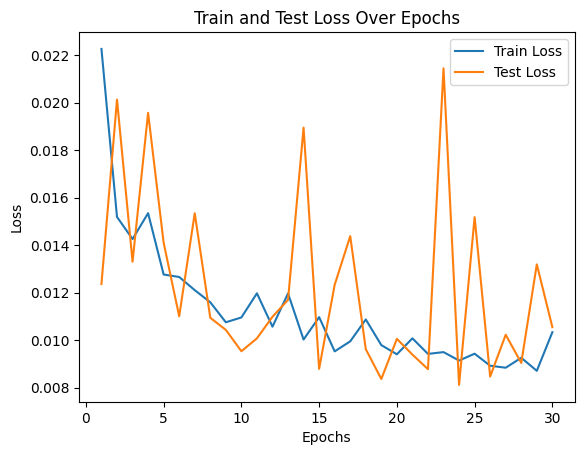

In [ ]:
plot_perfomance_results(loss_results= results)